In [1]:
import os
import sys
import json
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from utils.model_utils import unwrap_model
from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict, enc_linear_param_dict
from config.data_param_config import data_merge_config

from data_module.data_module import ALDataModule_v1
from model.enc_classifier_model import AE1DClassifier, AE1DMaxPoolBNClassifierModel
from model.AE_model import AECNN1DBNModel, AE1DMaxPoolBNModel

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=1000,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=8,
                    help=f"Number of class num use to train")

parser.add_argument("--model_name", type=str, default="4cnn_64",
                    help=f"Config name of model used for training")

parser.add_argument("--AE_ckpt_path", type=str, default="",
                    help=f"Config name of model used for training")

parser.add_argument("--linear_param", type=str, default="32",
                    help=f"Linear config name of model used for training")

parser.add_argument("--data_merge_param", type=str, default=None,
                    help=f"Data merge config name, find in config/data_param_config")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [3]:
random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [7]:
n_epochs = 200000
patience = n_epochs//500

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

model_name = f"{args.model_name}-8-1000-64"
AE_ckpt_abs_path = f"/nfs/ksdata/tran/HAR_AE/lightning_logs/11.1_AE/{model_name}/version_0/checkpoints/*.ckpt"
args.AE_ckpt_path = glob.glob(AE_ckpt_abs_path)[0]

log_save_dir = "lightning_logs"
log_save_name = f"15.2_enc_classify/{model_name}-{args.class_num}-{args.data_merge_param}-{args.train_limit_data}-{args.random_seed}"

In [8]:
from model.AE_model import AE1D_simple, AECNN1DModel, AE1DMaxPoolBNModel
AE1DMaxPoolBNModel.load_from_checkpoint(args.AE_ckpt_path)

AE1DMaxPoolBNModel(
  (enc_cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(8,), stride=(3,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 256, kernel_size=(7,), stride=(3,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (enc_linear): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec_linear): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=T

In [9]:
data_module = ALDataModule_v1.load_from_checkpoint(args.AE_ckpt_path, dataset_path=dataset_path)
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
if args.data_merge_param:
    label_merge_dict = data_merge_config[args.data_merge_param]
    print("before merge train", np.unique(data_module.train_label, return_counts=True))
    print("before merge val", np.unique(data_module.val_label, return_counts=True))
    print("before merge test", np.unique(data_module.test_label, return_counts=True))
    data_module.set_train_val_test_pred_merge_data(
        data_module.train_data,
        data_module.train_label,
        data_module.val_data,
        data_module.val_label,
        data_module.test_data,
        data_module.test_label,
        label_merge_dict,
        train_limit_number = args.train_limit_data,
        val_limit_number=1000,
        test_limit_number=1000,
        seed=42)
    print("after merge train", np.unique(data_module.train_label, return_counts=True))
    print("after merge val", np.unique(data_module.val_label, return_counts=True))
    print("after merge test", np.unique(data_module.test_label, return_counts=True))

limit_and_set_train_data limit_number= 1000
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [10]:
L.seed_everything(args.random_seed)

if args.data_merge_param:
    net = AE1DMaxPoolBNClassifierModel(
        AE1DMaxPoolBN_ckpt_path=args.AE_ckpt_path,
        optimizer = optimizer,
        optimizer_param = optimizer_param, 
        linear_channel_param = enc_linear_param_dict[args.linear_param],
        out_features=len(data_merge_config[args.data_merge_param]),
    )
else:
    net = AE1DMaxPoolBNClassifierModel(
        AE1DMaxPoolBN_ckpt_path=args.AE_ckpt_path,
        optimizer = optimizer,
        optimizer_param = optimizer_param, 
        linear_channel_param = enc_linear_param_dict[args.linear_param],
        out_features=args.class_num,
    )

Seed set to 42


In [ ]:
if not args.eval_mode:
    print(" ----------------------start training---------------------------")
    from lightning.pytorch.callbacks.early_stopping import EarlyStopping
    from lightning.pytorch.callbacks import ModelCheckpoint
    from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
    from lightning.pytorch.utilities.model_summary import ModelSummary
    
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
    csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )
    
    trainer = L.Trainer(
        logger=[tensorboard_logger, csv_logger],
        callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="gpu", 
        )
    
    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)
    
    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f)
    
    with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
        json.dump(args.__dict__, f, indent=4)

In [36]:
if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "15.2_enc_classify/{}-{}-{}-{}-{}"
    args.random_seed = "42"
    args.data_merge_param = "1"
    result_save_dict = {}
    raw_result_save_dict = {}
    
    for args.model_name in "4cnn_128 4cnn_64".split(" "):
        for args.train_limit_data in "5000".split(" "):
            args.train_limit_data = int(args.train_limit_data)
            for args.class_num in [8]:
                model_name = f"{args.model_name}-8-1000-64"
                
                save_model_folder = log_save_name.format(model_name, args.class_num, args.data_merge_param, args.train_limit_data, args.random_seed)
                save_model_dir = os.path.join(log_save_dir, save_model_folder)
                print(save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)
                net = AE1DMaxPoolBNClassifierModel.load_from_checkpoint(weight)
                
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
                if args.data_merge_param:
                    label_merge_dict = data_merge_config[args.data_merge_param]
                    print("before merge train", np.unique(data_module.train_label, return_counts=True))
                    print("before merge val", np.unique(data_module.val_label, return_counts=True))
                    print("before merge test", np.unique(data_module.test_label, return_counts=True))
                    data_module.set_train_val_test_pred_merge_data(
                        data_module.train_data,
                        data_module.train_label,
                        data_module.val_data,
                        data_module.val_label,
                        data_module.test_data,
                        data_module.test_label,
                        label_merge_dict,
                        train_limit_number = args.train_limit_data,
                        val_limit_number=1000,
                        test_limit_number=1000,
                        seed=42)

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                
                test_acc = trainer.logged_metrics["test_acc"]
                result_save_dict[save_model_folder] = test_acc

                output = trainer.predict(model=net, datamodule=data_module)
                pred = torch.argmax(torch.concat(output), dim=1)
                gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))

                pred_ravel = pred.numpy()
                gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))

                cf = confusion_matrix(gt_ravel, pred_ravel)
                
                raw_result_save_dict[save_model_folder] = cf.tolist()


15.2_enc_classify/4cnn_128-8-1000-64-8-1-5000-42
15.2_enc_classify/4cnn_128-8-1000-64-8-1-5000-42 lightning_logs/15.2_enc_classify/4cnn_128-8-1000-64-8-1-5000-42/version_0/checkpoints/sample_epoch=129-step=1690-val_loss=0.274467.ckpt
limit_and_set_train_data limit_number= 5000
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 5000


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([5000, 5000, 5000, 5000, 5000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 109.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 178.64it/s]
15.2_enc_classify/4cnn_64-8-1000-64-8-1-5000-42
15.2_enc_classify/4cnn_64-8-1000-64-8-1-5000-42 lightning_logs/15.2_enc_classify/4cnn_64-8-1000-64-8-1-5000-42/version_0/checkpoints/sample_epoch=289-step=3770-val_loss=0.242329.ckpt
limit_and_set_train_data limit_number= 5000
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge train (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
before merge val (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1001,  869, 1000, 1000, 1000, 1000, 1000]))
before merge test (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([1000, 1000,  869, 1000, 1000, 1000, 1000, 1000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_cla

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))
limit_filter_data_by_class limit_number= 1000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5.]), array([1000, 1000,  869, 1000, 1000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████████████████████████████| 10/10 [00:00<00:00, 160.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████████████████| 10/10 [00:00<00:00, 184.60it/s]


In [37]:
raw_result_save_dict

{'15.2_enc_classify/4cnn_128-8-1000-64-8-1-5000-42': [[942, 2, 0, 2, 54],
  [20, 956, 0, 16, 8],
  [3, 5, 858, 3, 0],
  [21, 23, 0, 931, 25],
  [251, 2, 0, 26, 721]],
 '15.2_enc_classify/4cnn_64-8-1000-64-8-1-5000-42': [[933, 1, 0, 2, 64],
  [16, 947, 1, 26, 10],
  [3, 5, 858, 3, 0],
  [21, 8, 1, 950, 20],
  [189, 1, 0, 24, 786]]}

In [38]:
with open("save_data/AE1000+classifier5000_merge5_result.json", "w") as f:
    json.dump(raw_result_save_dict, f, indent=2)

In [39]:
result_save_dict

{'15.2_enc_classify/4cnn_128-8-1000-64-8-1-5000-42': tensor(0.9053),
 '15.2_enc_classify/4cnn_64-8-1000-64-8-1-5000-42': tensor(0.9189)}

15.2_enc_classify/4cnn_128-8-1000-64-8-1-1000-42
15.2_enc_classify/4cnn_64-8-1000-64-8-1-1000-42


/tmp/ipykernel_25696/1805299384.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


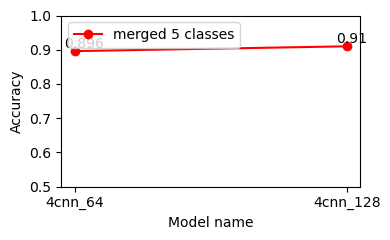

In [27]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(4, 2.5))
    args.random_seed = 42
    args.train_limit_data = "1000"
    
    for args.class_num in [8]:
        x = []
        for args.model_name in "4cnn_128 4cnn_64".split(" "):
            model_name = f"{args.model_name}-8-{args.train_limit_data}-64"
            save_model_folder = log_save_name.format(model_name, args.class_num, args.data_merge_param, args.train_limit_data, args.random_seed)
            print(save_model_folder)
            x.append(round(result_save_dict[save_model_folder].item(), 3))

        ax.plot(x, label=f"merged 5 classes", color="red", marker="o")
        for i, j in enumerate(x):
            ax.annotate(str(j),xy=(i-0.04,j+0.01))
        
    # ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model name')
    
    ax.set_xticks([0, 1], ["4cnn_64", "4cnn_128"])
    ax.set_ylim(0.5, 1)
    
    ax.legend()
    plt.tight_layout()